## Importing Libraries and Connecting to Database

In [6]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from modules.sql_utils import execute_chunk_query
from modules.visualize import plot_data

In [2]:
db = '../data/database/NYC_CRIME_DATABASE.db'
conn = sql.connect(db)

## Top 5 Crime Types by Borough

In [3]:
# Extract crime types and rank them by number of occurrences
q = '''
SELECT 
    borough,
    crime_type,
    crime_count,
    rank
FROM (
    SELECT 
        c.BORO AS borough,
        o.OFNS_DESC AS crime_type,
        COUNT(*) AS crime_count,
        ROW_NUMBER() OVER (PARTITION BY c.BORO ORDER BY COUNT(*) DESC) AS rank
    FROM 
        COMPLAINTS c
    JOIN 
        OFFENSE_CODES o ON c.KY_CD = o.KY_CD
    GROUP BY 
        c.BORO, o.OFNS_DESC
) AS ranked_crimes
WHERE rank in (1, 2, 3, 4, 5)
ORDER BY rank, borough;
'''

top5_crimes = execute_chunk_query(q, conn, verbosity = 1)
top5_crimes

Executing query 
SELECT 
    borough,
    crime_type,
    crime_count,
    rank
FROM (
    SELECT 
        c.BORO AS borough,
        o.OFNS_DESC AS crime_type,
        COUNT(*) AS crime_count,
        ROW_NUMBER() OVER (PARTITION BY c.BORO ORDER BY COUNT(*) DESC) AS rank
    FROM 
        COMPLAINTS c
    JOIN 
        OFFENSE_CODES o ON c.KY_CD = o.KY_CD
    GROUP BY 
        c.BORO, o.OFNS_DESC
) AS ranked_crimes
WHERE rank in (1, 2, 3, 4, 5)
ORDER BY rank, borough;
 on database.
Writing chunk 1.
Processing done. Returning dataframe.


,borough,crime_type,crime_count,rank
0,B,PETIT LARCENY,264063,1
1,K,PETIT LARCENY,425510,1
2,M,PETIT LARCENY,487041,1
3,Q,PETIT LARCENY,311016,1
4,S,HARRASSMENT 2,79403,1
5,B,HARRASSMENT 2,262470,2
6,K,HARRASSMENT 2,354103,2
7,M,GRAND LARCENY,294527,2
8,Q,HARRASSMENT 2,251340,2
9,S,PETIT LARCENY,63448,2


In [4]:
top5_crimes[top5_crimes['rank'] == 1]

,borough,crime_type,crime_count,rank
0,B,PETIT LARCENY,264063,1
1,K,PETIT LARCENY,425510,1
2,M,PETIT LARCENY,487041,1
3,Q,PETIT LARCENY,311016,1
4,S,HARRASSMENT 2,79403,1


## Ratio of Complaints to Arrests per Borough

In [3]:
# Query to extract aggregated complaint, arrest, and shooting data by year and borough
q = '''
SELECT
    sq1.*,
    sq2.complaints,
    sq3.shootings
FROM (
    SELECT
        A.BORO AS borough,
        CAST(SUBSTR(A.ARREST_DATE, 1, INSTR(A.ARREST_DATE, '-') - 1) AS INT) AS year,
        COUNT(A.ARREST_KEY) AS arrests
    FROM ARRESTS A
    GROUP BY year, A.BORO
) sq1
JOIN (
    SELECT
        C.BORO as borough,
        CAST(SUBSTR(C.CMPLNT_DATE, 1, INSTR(C.CMPLNT_DATE, '-') - 1) AS INT) AS year,
        COUNT(C.CMPLNT_KEY) AS complaints
    FROM COMPLAINTS C
    GROUP BY year, C.BORO
) sq2 ON sq1.borough = sq2.borough AND sq1.year = sq2.year
JOIN (
    SELECT
        S.BORO as borough,
        CAST(SUBSTR(S.OCCUR_DATE, 1, INSTR(S.OCCUR_DATE, '-') - 1) AS INT) AS year,
        COUNT(S.INCIDENT_KEY) AS shootings
    FROM SHOOTINGS S
    GROUP BY year, S.BORO
) sq3 on sq1.borough = sq3.borough AND sq1.year = sq3.year
ORDER BY sq1.year ASC;
'''

borough_year_agg_data = execute_chunk_query(q, conn, verbosity = 1)
borough_year_agg_data

Executing query 
SELECT
    sq1.*,
    sq2.complaints,
    sq3.shootings
FROM (
    SELECT
        A.BORO AS borough,
        CAST(SUBSTR(A.ARREST_DATE, 1, INSTR(A.ARREST_DATE, '-') - 1) AS INT) AS year,
        COUNT(A.ARREST_KEY) AS arrests
    FROM ARRESTS A
    GROUP BY year, A.BORO
) sq1
JOIN (
    SELECT
        C.BORO as borough,
        CAST(SUBSTR(C.CMPLNT_DATE, 1, INSTR(C.CMPLNT_DATE, '-') - 1) AS INT) AS year,
        COUNT(C.CMPLNT_KEY) AS complaints
    FROM COMPLAINTS C
    GROUP BY year, C.BORO
) sq2 ON sq1.borough = sq2.borough AND sq1.year = sq2.year
JOIN (
    SELECT
        S.BORO as borough,
        CAST(SUBSTR(S.OCCUR_DATE, 1, INSTR(S.OCCUR_DATE, '-') - 1) AS INT) AS year,
        COUNT(S.INCIDENT_KEY) AS shootings
    FROM SHOOTINGS S
    GROUP BY year, S.BORO
) sq3 on sq1.borough = sq3.borough AND sq1.year = sq3.year
ORDER BY sq1.year ASC;
 on database.
Writing chunk 1.
Processing done. Returning dataframe.


,borough,year,arrests,complaints,shootings
0,B,2006,83642,110243,568
1,K,2006,102820,157146,850
2,M,2006,101957,126680,288
3,Q,2006,69969,104756,296
4,S,2006,12365,26981,53
...,...,...,...,...,...
85,B,2023,52905,117546,426
86,K,2023,62178,151040,402
87,M,2023,52004,129634,178
88,Q,2023,47553,119537,171


In [4]:
# Regrouping via year or borough
# We can technically create the dataframes generated by these operations using SQL
# but it is easy enough to create them using pandas operations while only having to query once
borough_agg_data = borough_year_agg_data.drop('year', axis = 1).groupby('borough').sum().reset_index()
year_agg_data = borough_year_agg_data.drop('borough', axis = 1).groupby('year').sum().reset_index()

/cdrive/Projects/Pace/Pace-Classwork/Scalable-Databases-CS673/Projects/Midterm/src/modules/visualize.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)


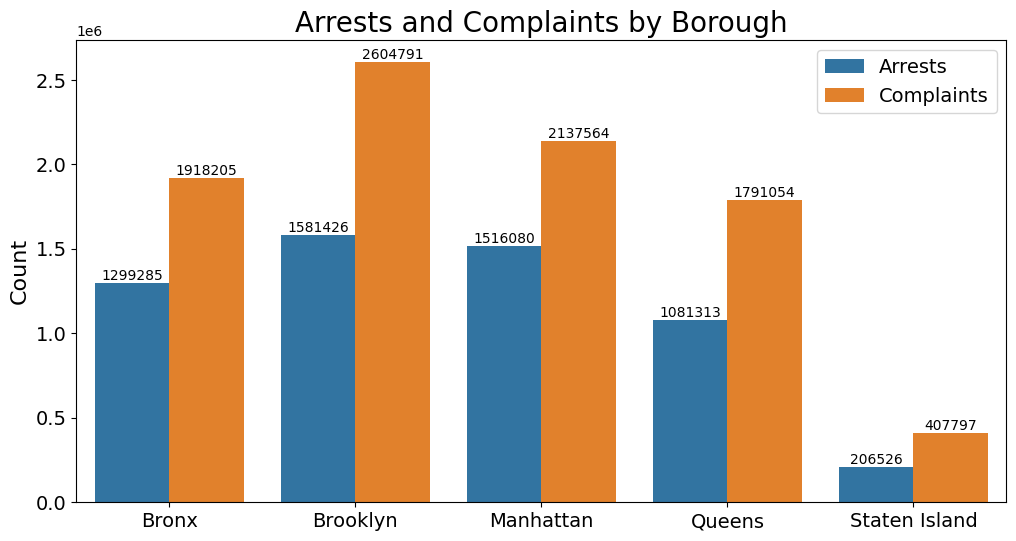

In [7]:
# Plotting and saving arrests and complaints by borough
func_params = {'x': 'borough', 'y': 'value', 'hue': 'variable', 'palette': 'tab10'}
text_params = {'title': 'Arrests and Complaints by Borough', 'xlabel': '',
               'ylabel': 'Count', 'tick_labels': ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']}
legend_params = {'title': None, 'labels': ['Arrests', 'Complaints'], 'fontsize': 14}
plot_params = {'agg_type': 'melt', 'fig_width': 12, 'annotate_params': {'labelsize': 10, 'precision': 0},
               'save': True, 'save_path': '../visualizations/arrests_complaints_borough.png'}

plot_data(func = sns.barplot, data = borough_agg_data, groupby_cols = ['borough'],
          target_cols = ['arrests', 'complaints'], func_params = func_params,
          text_params = text_params, legend_params = legend_params, **plot_params);

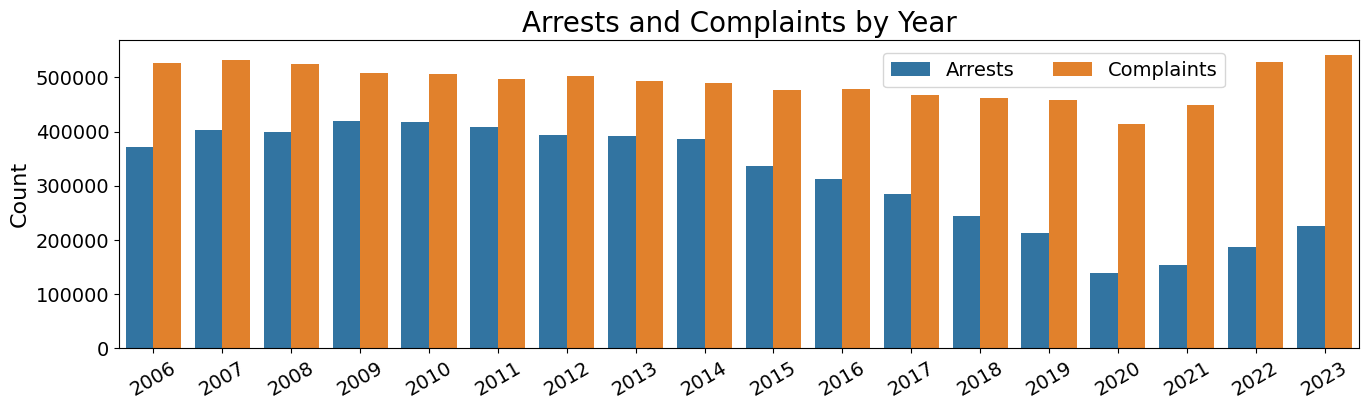

In [8]:
# Plotting and saving arrests and complaints by year
func_params = {'x': 'year', 'y': 'value', 'hue': 'variable', 'palette': 'tab10'}
text_params = {'title': 'Arrests and Complaints by Year',
                'xlabel': '', 'ylabel': 'Count', 'rotation': 30}
legend_params = {'title': None, 'labels': ['Arrests', 'Complaints'], 'ncols': 2,
                 'fontsize': 14, 'bbox_to_anchor': (0.9, 0.99)}
plot_params = {'agg_type': 'melt', 'fig_width': 16, 'fig_height': 4, 'annotate': False,
               'save': True, 'save_path': '../visualizations/arrests_complaints_year.png'}

plot_data(func = sns.barplot, data = year_agg_data, groupby_cols = ['year'],
          target_cols = ['arrests', 'complaints'], func_params = func_params,
          text_params = text_params, legend_params = legend_params, **plot_params);

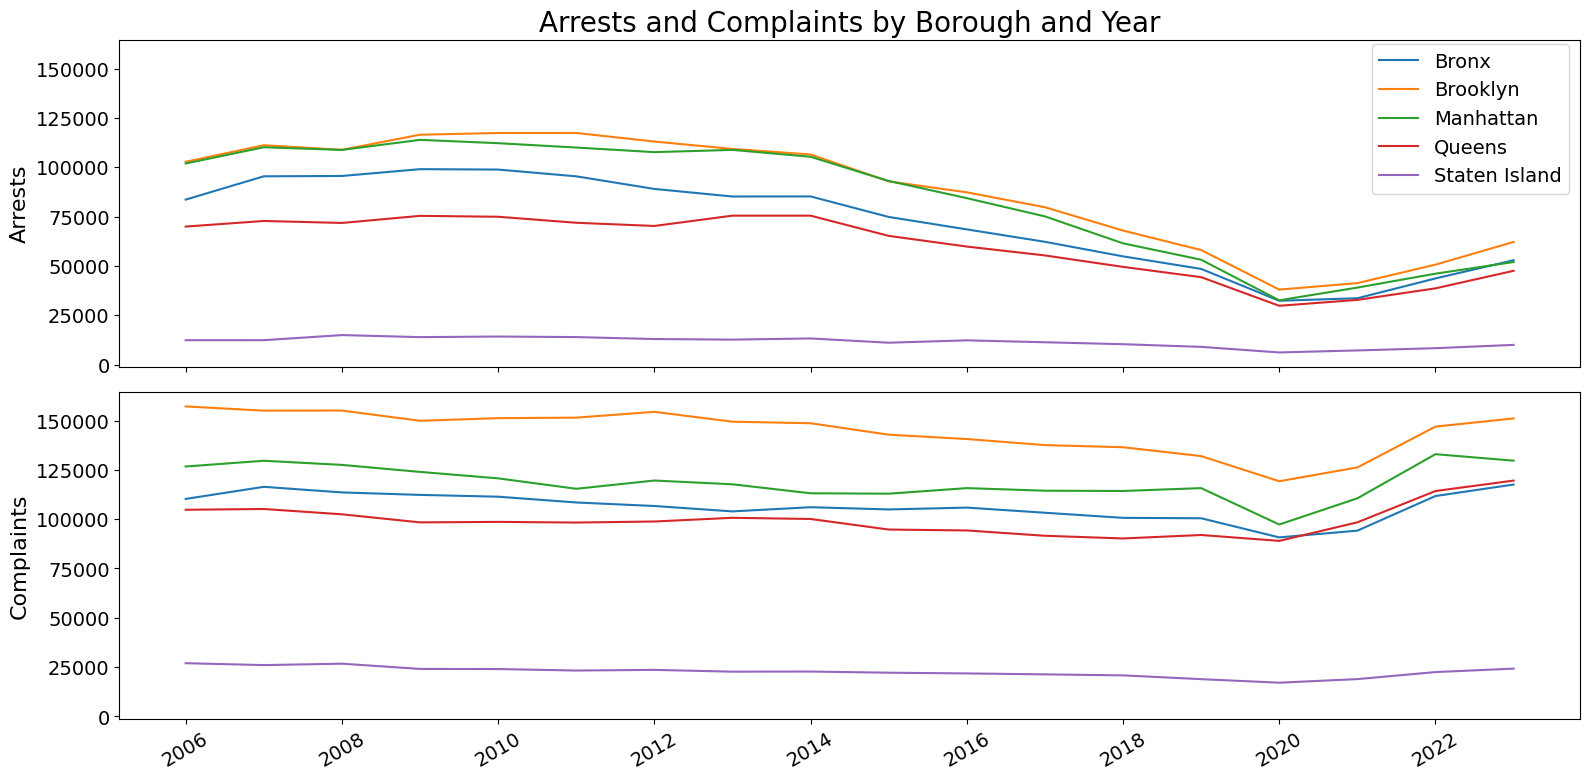

In [8]:
# Plotting and saving arrests and complaints by borough and year
func_params = [{'x': 'year', 'y': 'arrests', 'hue': 'borough', 'palette': 'tab10'},
               {'x': 'year', 'y': 'complaints', 'hue': 'borough', 'palette': 'tab10'}]
text_params = [{'title': 'Arrests and Complaints by Borough and Year', 'xlabel': '', 'ylabel': 'Arrests'},
               {'title': '', 'xlabel': '', 'ylabel': 'Complaints', 'rotation': 30}]
legend_params = {'title': None, 'labels': ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
                 'fontsize': 14, 'bbox_to_anchor': (0.99, 0.95)}
plot_params = {'agg_type': 'groupby', 'fig_width': 16, 'fig_height': 4, 'annotate': False, 'save': False}

fig, ax = plot_data(func = sns.lineplot, data = borough_year_agg_data, groupby_cols = ['year', 'borough'],
                    target_cols = ['arrests', 'complaints'], func_params = func_params,
                    text_params = text_params, legend_params = legend_params, **plot_params);

# Force x-labels to integers for whole years
ax[1].xaxis.set_major_locator(MaxNLocator(integer = True));

plt.savefig('../visualizations/arrests_complaints_borough_year.png', bbox_inches = 'tight');

### Per Capita Arrests / Complaints by Borough

In [10]:
# Extracting relevant population data - dataset ranges from 2006 to 2023
q = '''
SELECT BORO_CD, "2000", "2010", "2020" FROM BOROUGHS
'''

population_data = execute_chunk_query(q, conn, verbosity = 1)

Executing query 
SELECT BORO_CD, "2000", "2010", "2020" FROM BOROUGHS
 on database.
Writing chunk 1.
Processing done. Returning dataframe.


In [11]:
population_data

,BORO_CD,2000,2010,2020
0,T,8008278,8242624,8550971
1,B,1332650,1385108,1446788
2,K,2465326,2552911,2648452
3,M,1537195,1585873,1638281
4,Q,2229379,2250002,2330295
5,S,443728,468730,487155


In [12]:
# Calculating per capita data - population data is formatted like a lookup table
crimes_per_capita = borough_year_agg_data.copy()
crimes_per_capita['population'] = crimes_per_capita.apply(lambda x:
                            population_data.loc[population_data.BORO_CD == x.borough][f'20{str(x.year)[2]}0'].iloc[0],
                                                          axis = 1)
crimes_per_capita['arrests_per_capita'] = crimes_per_capita.arrests / crimes_per_capita.population
crimes_per_capita['complaints_per_capita'] = crimes_per_capita.complaints / crimes_per_capita.population
crimes_per_capita['shootings_per_capita'] = crimes_per_capita.shootings / crimes_per_capita.population
crimes_per_capita.drop(['arrests', 'complaints', 'shootings', 'population'], axis = 1, inplace = True)

/cdrive/Projects/Pace/Pace-Classwork/Scalable-Databases-CS673/Projects/Midterm/src/modules/visualize.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)


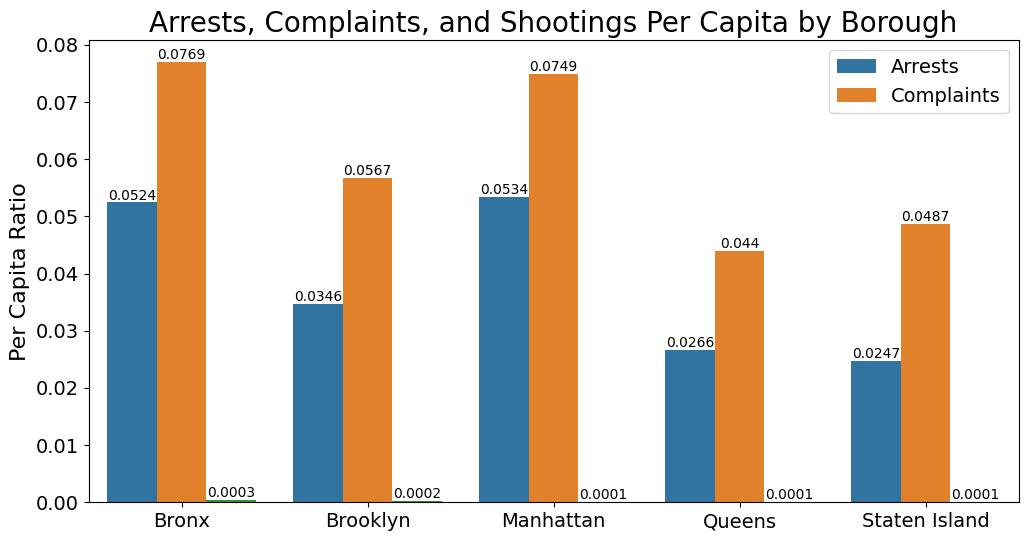

In [13]:
# Plotting and saving per capita data by borough
func_params = {'x': 'borough', 'y': 'value', 'hue': 'variable', 'palette': 'tab10', 'errorbar': None}
text_params = {'title': 'Arrests, Complaints, and Shootings Per Capita by Borough',
               'xlabel': '', 'ylabel': 'Per Capita Ratio',
               'tick_labels': ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']}
legend_params = {'title': None, 'labels': ['Arrests', 'Complaints'], 'fontsize': 14}
plot_params = {'agg_type': 'melt', 'fig_width': 12, 'annotate_params': {'labelsize': 10, 'precision': 4},
               'save': True, 'save_path': '../visualizations/per_capita_borough.png'}

plot_data(func = sns.barplot, data = crimes_per_capita, groupby_cols = ['borough'],
          target_cols = ['arrests_per_capita', 'complaints_per_capita', 'shootings_per_capita'],
          func_params = func_params, text_params = text_params, legend_params = legend_params, **plot_params);

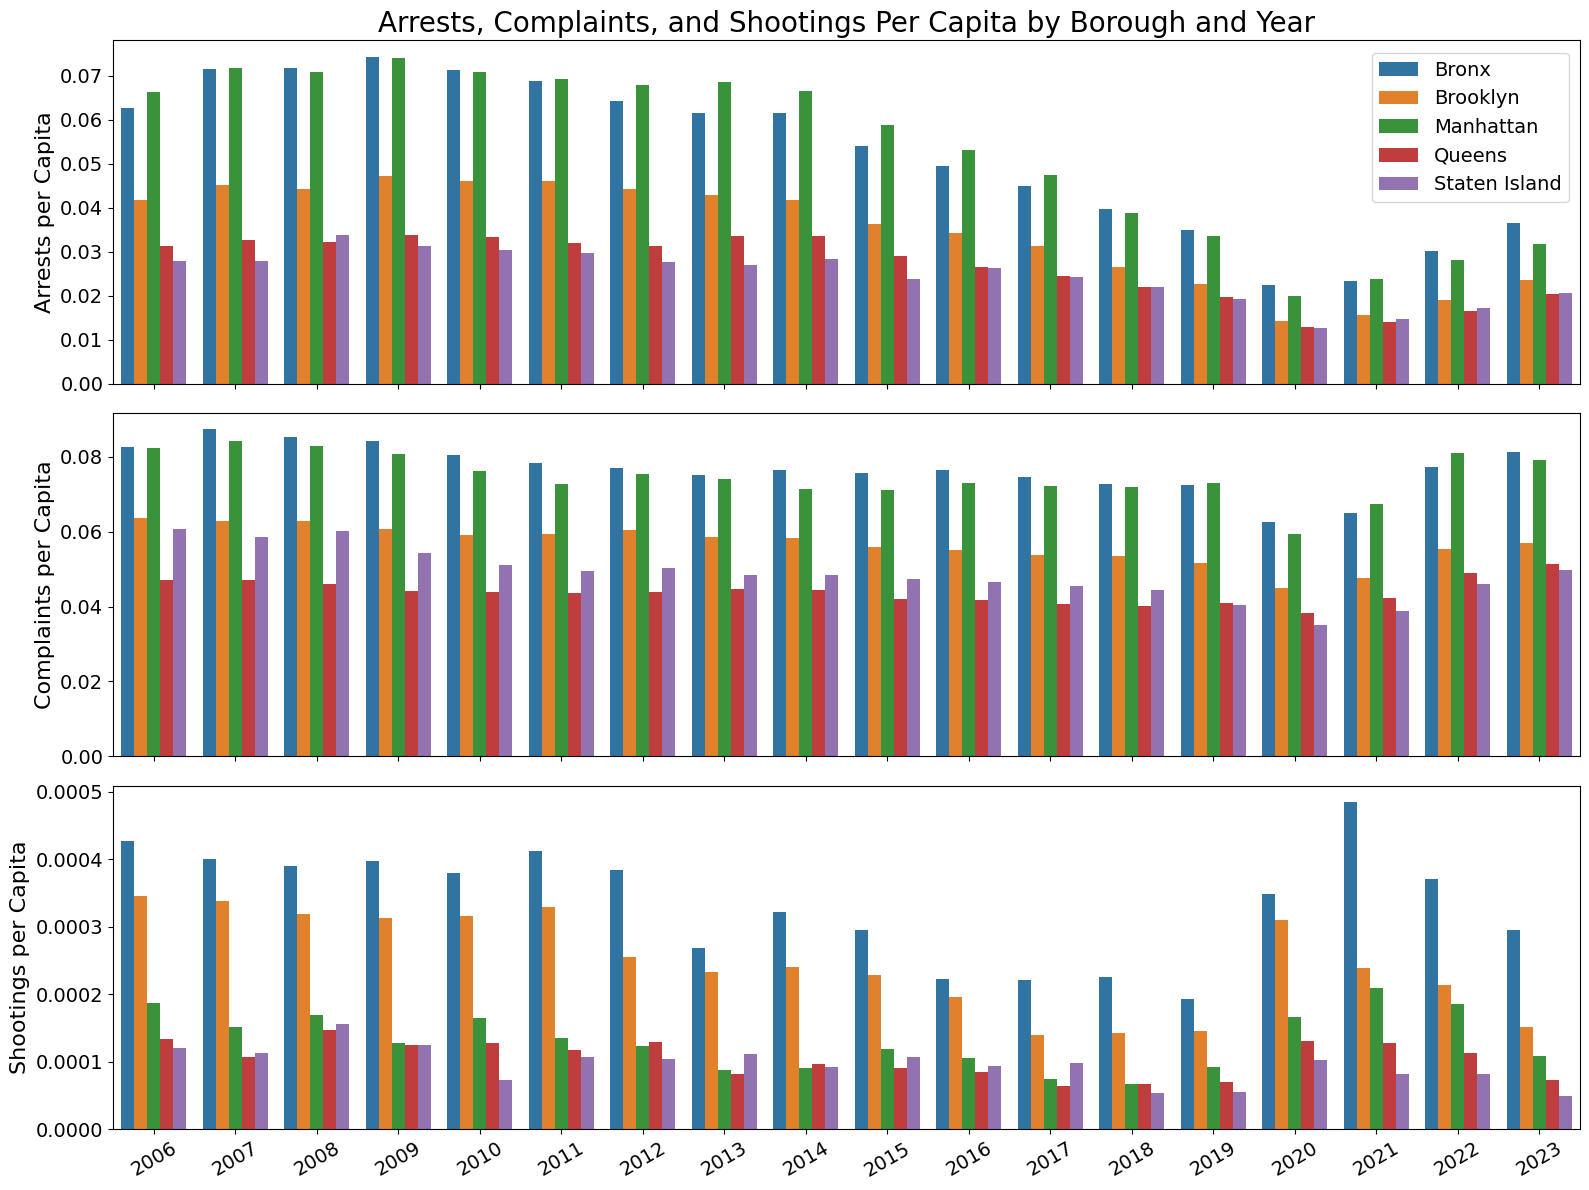

In [14]:
# Plotting and saving per capita data by borough and year
func_params = [{'x': 'year', 'y': 'arrests_per_capita', 'hue': 'borough', 'palette': 'tab10'},
               {'x': 'year', 'y': 'complaints_per_capita', 'hue': 'borough', 'palette': 'tab10'},
               {'x': 'year', 'y': 'shootings_per_capita', 'hue': 'borough', 'palette': 'tab10'}]
text_params = [{'title': 'Arrests, Complaints, and Shootings Per Capita by Borough and Year',
                'xlabel': '', 'ylabel': 'Arrests per Capita'},
               {'title': '', 'xlabel': '', 'ylabel': 'Complaints per Capita'},
               {'title': '', 'xlabel': '', 'ylabel': 'Shootings per Capita', 'rotation': 30}]
legend_params = {'title': None, 'labels': ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
                 'fontsize': 14, 'bbox_to_anchor': (0.99, 0.96)}
plot_params = {'agg_type': 'groupby', 'fig_width': 16, 'fig_height': 4, 'annotate': False, 'sharey': False,
               'save': True, 'save_path': '../visualizations/per_capita_borough_year.png'}

fig, ax = plot_data(func = sns.barplot, data = crimes_per_capita, groupby_cols = ['year', 'borough'],
          target_cols = ['arrests_per_capita', 'complaints_per_capita', 'shootings_per_capita'],
          func_params = func_params, text_params = text_params, legend_params = legend_params, **plot_params);

# ax[2].xaxis.set_major_locator(MaxNLocator(integer = True));

## Demographic Statistics (Race, Age, Sex)

In [15]:
# Query to extract aggregate complaint statistics based on age
q = '''
SELECT
    COUNT(CMPLNT_KEY) AS complaints,
    SUSP_AGE_GROUP AS susp_age,
    VIC_AGE_GROUP as vic_age
FROM COMPLAINTS
WHERE SUSP_AGE_GROUP <> "UNKNOWN" AND VIC_AGE_GROUP <> "UNKNOWN"
GROUP BY SUSP_AGE_GROUP, VIC_AGE_GROUP
ORDER BY SUSP_AGE_GROUP DESC;
'''

age_data = execute_chunk_query(q, conn, verbosity = 1)
age_data

Executing query 
SELECT
    COUNT(CMPLNT_KEY) AS complaints,
    SUSP_AGE_GROUP AS susp_age,
    VIC_AGE_GROUP as vic_age
FROM COMPLAINTS
WHERE SUSP_AGE_GROUP <> "UNKNOWN" AND VIC_AGE_GROUP <> "UNKNOWN"
GROUP BY SUSP_AGE_GROUP, VIC_AGE_GROUP
ORDER BY SUSP_AGE_GROUP DESC;
 on database.
Writing chunk 1.
Processing done. Returning dataframe.


,complaints,susp_age,vic_age
0,18962,<18,18-24
1,42135,<18,25-44
2,24045,<18,45-64
3,3610,<18,65+
4,81067,<18,<18
5,2325,65+,18-24
6,13603,65+,25-44
7,16935,65+,45-64
8,8791,65+,65+
9,1506,65+,<18


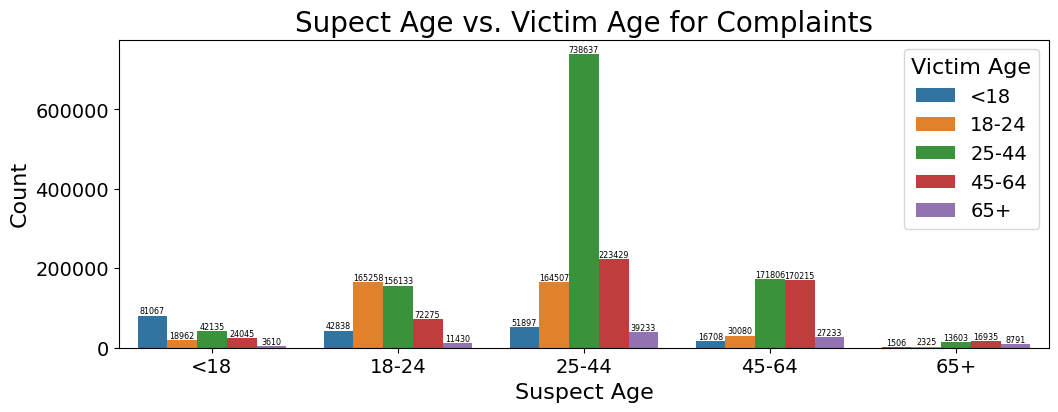

In [16]:
# Plotting and saving age on age data
func_params = {'x': 'susp_age', 'y': 'complaints', 'hue': 'vic_age', 'palette': 'tab10', 'errorbar': None,
               'order': ['<18', '18-24', '25-44', '45-64', '65+'],
               'hue_order': ['<18', '18-24', '25-44', '45-64', '65+']}
text_params = {'title': 'Supect Age vs. Victim Age for Complaints',
               'xlabel': 'Suspect Age', 'ylabel': 'Count'}
legend_params = {'title': 'Victim Age', 'title_fontsize': 16, 'fontsize': 14}
plot_params = {'agg_type': 'groupby', 'fig_width': 12, 'fig_height': 4,
               'annotate_params': {'labelsize': 5.75, 'precision': 0},
               'save': True, 'save_path': '../visualizations/age_on_age.png'}

plot_data(func = sns.barplot, data = age_data, groupby_cols = ['susp_age', 'vic_age'],
          target_cols = ['complaints'],
          func_params = func_params, text_params = text_params, legend_params = legend_params, **plot_params);

In [17]:
# Query to extract aggregate complaint statistics based on sex
q = '''
SELECT
    COUNT(CMPLNT_KEY) AS complaints,
    SUSP_SEX AS susp_sex,
    VIC_SEX as vic_sex
FROM COMPLAINTS
WHERE SUSP_SEX <> "U" AND VIC_SEX <> "U"
GROUP BY SUSP_SEX, VIC_SEX
ORDER BY SUSP_SEX DESC;
'''

sex_data = execute_chunk_query(q, conn, verbosity = 1)
sex_data

Executing query 
SELECT
    COUNT(CMPLNT_KEY) AS complaints,
    SUSP_SEX AS susp_sex,
    VIC_SEX as vic_sex
FROM COMPLAINTS
WHERE SUSP_SEX <> "U" AND VIC_SEX <> "U"
GROUP BY SUSP_SEX, VIC_SEX
ORDER BY SUSP_SEX DESC;
 on database.
Writing chunk 1.
Processing done. Returning dataframe.


,complaints,susp_sex,vic_sex
0,1416997,M,F
1,992479,M,M
2,538112,F,F
3,290250,F,M


/cdrive/Projects/Pace/Pace-Classwork/Scalable-Databases-CS673/Projects/Midterm/src/modules/visualize.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)


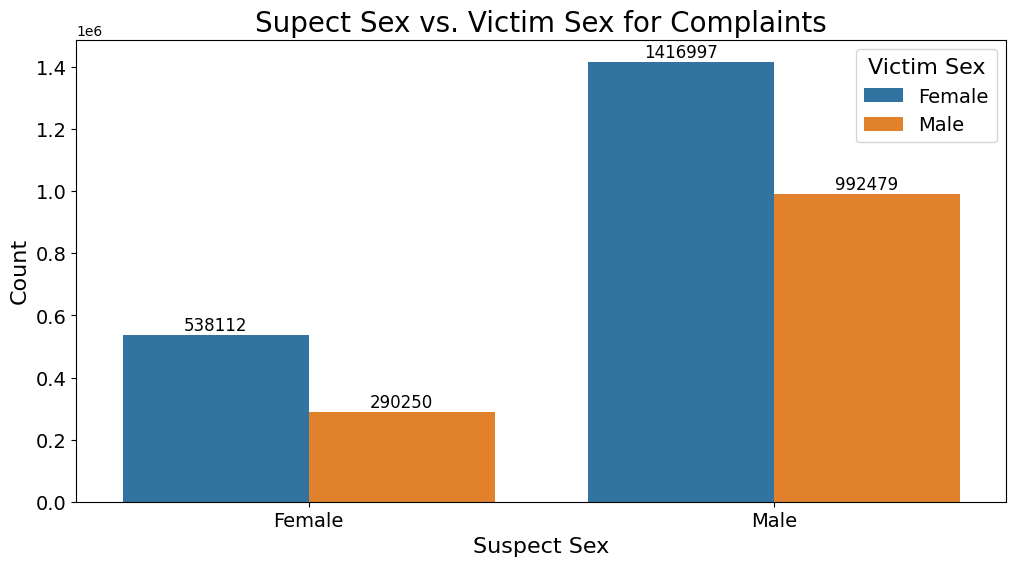

In [18]:
# Plotting and saving sex on sex data
func_params = {'x': 'susp_sex', 'y': 'complaints', 'hue': 'vic_sex', 'palette': 'tab10', 'errorbar': None}
text_params = {'title': 'Supect Sex vs. Victim Sex for Complaints',
               'xlabel': 'Suspect Sex', 'ylabel': 'Count',
               'tick_labels': ['Female', 'Male']}
legend_params = {'title': 'Victim Sex', 'labels': ['Female', 'Male'], 'title_fontsize': 16, 'fontsize': 14}
plot_params = {'agg_type': 'groupby', 'fig_width': 12, 'fig_height': 6,
               'annotate_params': {'labelsize': 12, 'precision': 0},
               'save': True, 'save_path': '../visualizations/sex_on_sex.png'}

plot_data(func = sns.barplot, data = sex_data, groupby_cols = ['susp_sex', 'vic_sex'],
          target_cols = ['complaints'],
          func_params = func_params, text_params = text_params, legend_params = legend_params, **plot_params);

In [19]:
# Query to extract aggregate complaint statistics based on race
q = '''
SELECT
    COUNT(CMPLNT_KEY) AS complaints,
    SUSP_RACE AS susp_race,
    VIC_RACE AS vic_race
FROM COMPLAINTS
WHERE SUSP_RACE <> "UNKNOWN" AND VIC_RACE <> "UNKNOWN"
GROUP BY SUSP_RACE, VIC_RACE
ORDER BY SUSP_RACE DESC;
'''

race_data = execute_chunk_query(q, conn, verbosity = 1)
race_data

Executing query 
SELECT
    COUNT(CMPLNT_KEY) AS complaints,
    SUSP_RACE AS susp_race,
    VIC_RACE AS vic_race
FROM COMPLAINTS
WHERE SUSP_RACE <> "UNKNOWN" AND VIC_RACE <> "UNKNOWN"
GROUP BY SUSP_RACE, VIC_RACE
ORDER BY SUSP_RACE DESC;
 on database.
Writing chunk 1.
Processing done. Returning dataframe.


,complaints,susp_race,vic_race
0,2249,WHITE HISPANIC,AMERICAN INDIAN/ALASKAN NATIVE
1,30232,WHITE HISPANIC,ASIAN / PACIFIC ISLANDER
2,84109,WHITE HISPANIC,BLACK
3,42378,WHITE HISPANIC,BLACK HISPANIC
4,82877,WHITE HISPANIC,WHITE
5,407770,WHITE HISPANIC,WHITE HISPANIC
6,2023,WHITE,AMERICAN INDIAN/ALASKAN NATIVE
7,26052,WHITE,ASIAN / PACIFIC ISLANDER
8,38054,WHITE,BLACK
9,7006,WHITE,BLACK HISPANIC


/cdrive/Projects/Pace/Pace-Classwork/Scalable-Databases-CS673/Projects/Midterm/src/modules/visualize.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)


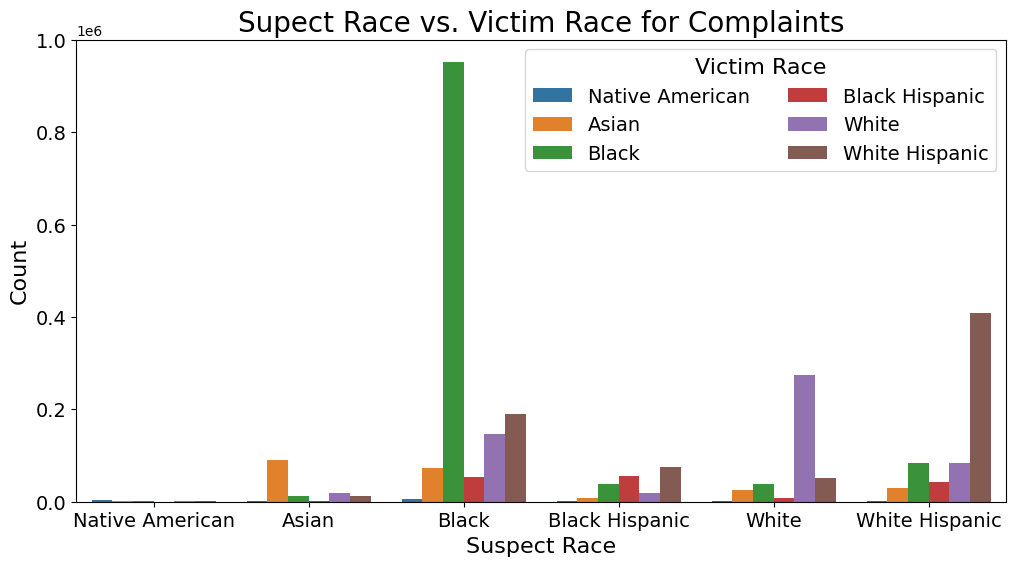

In [20]:
# Plotting and saving race on race data
func_params = {'x': 'susp_race', 'y': 'complaints', 'hue': 'vic_race', 'palette': 'tab10', 'errorbar': None}
text_params = {'title': 'Supect Race vs. Victim Race for Complaints',
               'xlabel': 'Suspect Race', 'ylabel': 'Count',
               'tick_labels': ['Native American', 'Asian', 'Black', 'Black Hispanic',
                               'White', 'White Hispanic']}
legend_params = {'title': 'Victim Race', 'title_fontsize': 16, 'fontsize': 14, 'ncols': 2,
                 'labels': ['Native American', 'Asian', 'Black', 'Black Hispanic',
                               'White', 'White Hispanic']}
plot_params = {'agg_type': 'groupby', 'fig_width': 12, 'fig_height': 6,
               'annotate': False, 'save': True, 'save_path': '../visualizations/race_on_race.png'}

plot_data(func = sns.barplot, data = race_data, groupby_cols = ['susp_race', 'vic_race'],
          target_cols = ['complaints'],
          func_params = func_params, text_params = text_params, legend_params = legend_params, **plot_params);

## Crime Severity Statistics (Violations, Misdemeanors, Felonies)

In [3]:
# Query to extract aggregate arrest statistics based on crime severity categorization
q = '''
SELECT
    BORO AS borough,
    LAW_CAT_CD AS crime_severity,
    COUNT(ARREST_KEY) AS arrests
FROM ARRESTS
GROUP BY BORO, LAW_CAT_CD
ORDER BY BORO DESC;
'''

borough_severity_data = execute_chunk_query(q, conn, verbosity = 1)
borough_severity_data

Executing query 
SELECT
    BORO AS borough,
    LAW_CAT_CD AS crime_severity,
    COUNT(ARREST_KEY) AS arrests
FROM ARRESTS
GROUP BY BORO, LAW_CAT_CD
ORDER BY BORO DESC;
 on database.
Writing chunk 1.
Processing done. Returning dataframe.


,borough,crime_severity,arrests
0,S,F,65931
1,S,I,554
2,S,M,138936
3,S,V,1105
4,Q,F,332389
5,Q,I,12518
6,Q,M,676513
7,Q,V,59893
8,M,F,390347
9,M,I,4391


/cdrive/Projects/Pace/Pace-Classwork/Scalable-Databases-CS673/Projects/Midterm/src/modules/visualize.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)


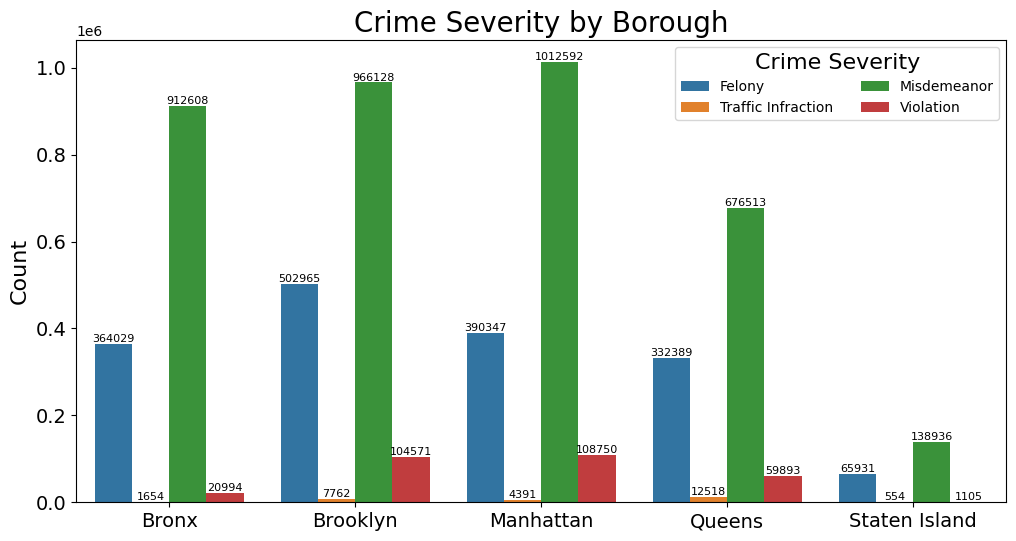

In [22]:
# Plotting and saving crime severity by borough
func_params = {'x': 'borough', 'y': 'arrests', 'hue': 'crime_severity', 'palette': 'tab10', 'errorbar': None}
text_params = {'title': 'Crime Severity by Borough', 'xlabel': '', 'ylabel': 'Count',
               'tick_labels': ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']}
legend_params = {'title': 'Crime Severity', 'title_fontsize': 16, 'fontsize': 10, 'ncols': 2,
                 'labels': ['Felony', 'Traffic Infraction', 'Misdemeanor', 'Violation']}
plot_params = {'agg_type': 'groupby', 'fig_width': 12, 'fig_height': 6,
               'annotate_params': {'labelsize': 8},
               'save': True, 'save_path': '../visualizations/crime_severity_borough.png'}

plot_data(func = sns.barplot, data = borough_severity_data, groupby_cols = ['borough', 'crime_severity'],
          target_cols = ['arrests'], func_params = func_params,
          text_params = text_params, legend_params = legend_params, **plot_params);

## Murders by Shooting per Borough

In [8]:
# Query to extract shootings where a murder occurred by borough
q = '''
SELECT BORO AS borough, COUNT(DISTINCT INCIDENT_KEY) AS murder_count
FROM SHOOTINGS
WHERE STATISTICAL_MURDER_FLAG = TRUE
GROUP BY BORO;
'''

murder_shootings_data = execute_chunk_query(q, conn, verbosity = 1)
murder_shootings_data

Executing query 
SELECT BORO AS borough, COUNT(DISTINCT INCIDENT_KEY) AS murder_count
FROM SHOOTINGS
WHERE STATISTICAL_MURDER_FLAG = TRUE
GROUP BY BORO;
 on database.
Writing chunk 1.
Processing done. Returning dataframe.


,borough,murder_count
0,B,1184
1,K,1797
2,M,510
3,Q,665
4,S,137


/cdrive/Projects/Pace/Pace-Classwork/Scalable-Databases-CS673/Projects/Midterm/src/modules/visualize.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)


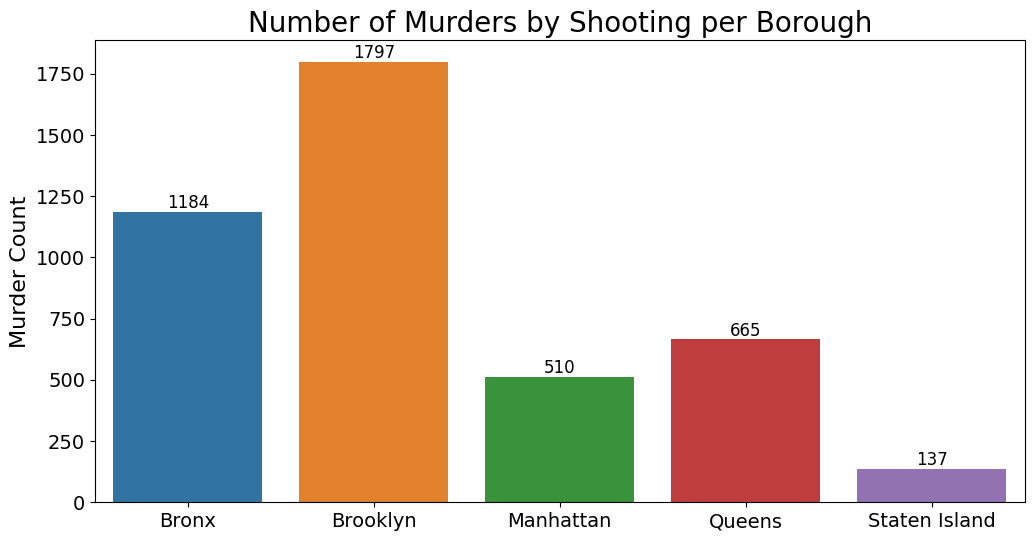

In [16]:
# Plotting and saving muders by shooting by borough
func_params = {'x': 'borough', 'y': 'murder_count', 'hue': 'borough', 'palette': 'tab10', 'errorbar': None}
text_params = {'title': 'Number of Murders by Shooting per Borough', 'xlabel': '', 'ylabel': 'Murder Count',
               'tick_labels': ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']}
legend_params = None
plot_params = {'agg_type': 'groupby', 'fig_width': 12, 'fig_height': 6,
               'annotate_params': {'labelsize': 12},
               'save': True, 'save_path': '../visualizations/shooting_murders_borough.png'}

plot_data(func = sns.barplot, data = murder_shootings_data, groupby_cols = ['borough'],
          target_cols = ['murder_count'], func_params = func_params,
          text_params = text_params, legend_params = legend_params, **plot_params);

## Precinct Statistics for Crimes

In [9]:
# Query to extract aggregate arrest, complaints, and shootings statistics for each precinct
q = '''
SELECT
    sq1.*,
    sq2.complaints,
    sq3.shootings
FROM (
    SELECT
        A.PRECINCT_CD AS precinct,
        CAST(SUBSTR(A.ARREST_DATE, 1, INSTR(A.ARREST_DATE, '-') - 1) AS INT) AS year,
        COUNT(A.ARREST_KEY) AS arrests
    FROM ARRESTS A
    GROUP BY year, A.PRECINCT_CD
) sq1
JOIN (
    SELECT
        C.PRECINCT_CD as precinct,
        CAST(SUBSTR(C.CMPLNT_DATE, 1, INSTR(C.CMPLNT_DATE, '-') - 1) AS INT) AS year,
        COUNT(C.CMPLNT_KEY) AS complaints
    FROM COMPLAINTS C
    GROUP BY year, C.PRECINCT_CD
) sq2 ON sq1.precinct = sq2.precinct AND sq1.year = sq2.year
JOIN (
    SELECT
        S.PRECINCT_CD as precinct,
        CAST(SUBSTR(S.OCCUR_DATE, 1, INSTR(S.OCCUR_DATE, '-') - 1) AS INT) AS year,
        COUNT(S.INCIDENT_KEY) AS shootings
    FROM SHOOTINGS S
    GROUP BY year, S.PRECINCT_CD
) sq3 on sq1.precinct = sq3.precinct AND sq1.year = sq3.year
ORDER BY sq1.year ASC;
'''

precinct_year_agg_data = execute_chunk_query(q, conn, verbosity = 1)
precinct_year_agg_data

Executing query 
SELECT
    sq1.*,
    sq2.complaints,
    sq3.shootings
FROM (
    SELECT
        A.PRECINCT_CD AS precinct,
        CAST(SUBSTR(A.ARREST_DATE, 1, INSTR(A.ARREST_DATE, '-') - 1) AS INT) AS year,
        COUNT(A.ARREST_KEY) AS arrests
    FROM ARRESTS A
    GROUP BY year, A.PRECINCT_CD
) sq1
JOIN (
    SELECT
        C.PRECINCT_CD as precinct,
        CAST(SUBSTR(C.CMPLNT_DATE, 1, INSTR(C.CMPLNT_DATE, '-') - 1) AS INT) AS year,
        COUNT(C.CMPLNT_KEY) AS complaints
    FROM COMPLAINTS C
    GROUP BY year, C.PRECINCT_CD
) sq2 ON sq1.precinct = sq2.precinct AND sq1.year = sq2.year
JOIN (
    SELECT
        S.PRECINCT_CD as precinct,
        CAST(SUBSTR(S.OCCUR_DATE, 1, INSTR(S.OCCUR_DATE, '-') - 1) AS INT) AS year,
        COUNT(S.INCIDENT_KEY) AS shootings
    FROM SHOOTINGS S
    GROUP BY year, S.PRECINCT_CD
) sq3 on sq1.precinct = sq3.precinct AND sq1.year = sq3.year
ORDER BY sq1.year ASC;
 on database.
Writing chunk 1.
Processing done. Returning dataframe.


,precinct,year,arrests,complaints,shootings
0,5,2006,5027,4150,3
1,6,2006,3860,5582,1
2,7,2006,3085,3820,8
3,9,2006,4145,6360,3
4,10,2006,3608,4952,15
...,...,...,...,...,...
1269,115,2023,3584,9484,6
1270,120,2023,4902,9196,19
1271,121,2023,2510,6724,1
1272,122,2023,1573,5415,2


In [5]:
# Regrouping by precinct
precinct_agg_data = precinct_year_agg_data.drop('year', axis = 1).groupby('precinct').sum().reset_index()

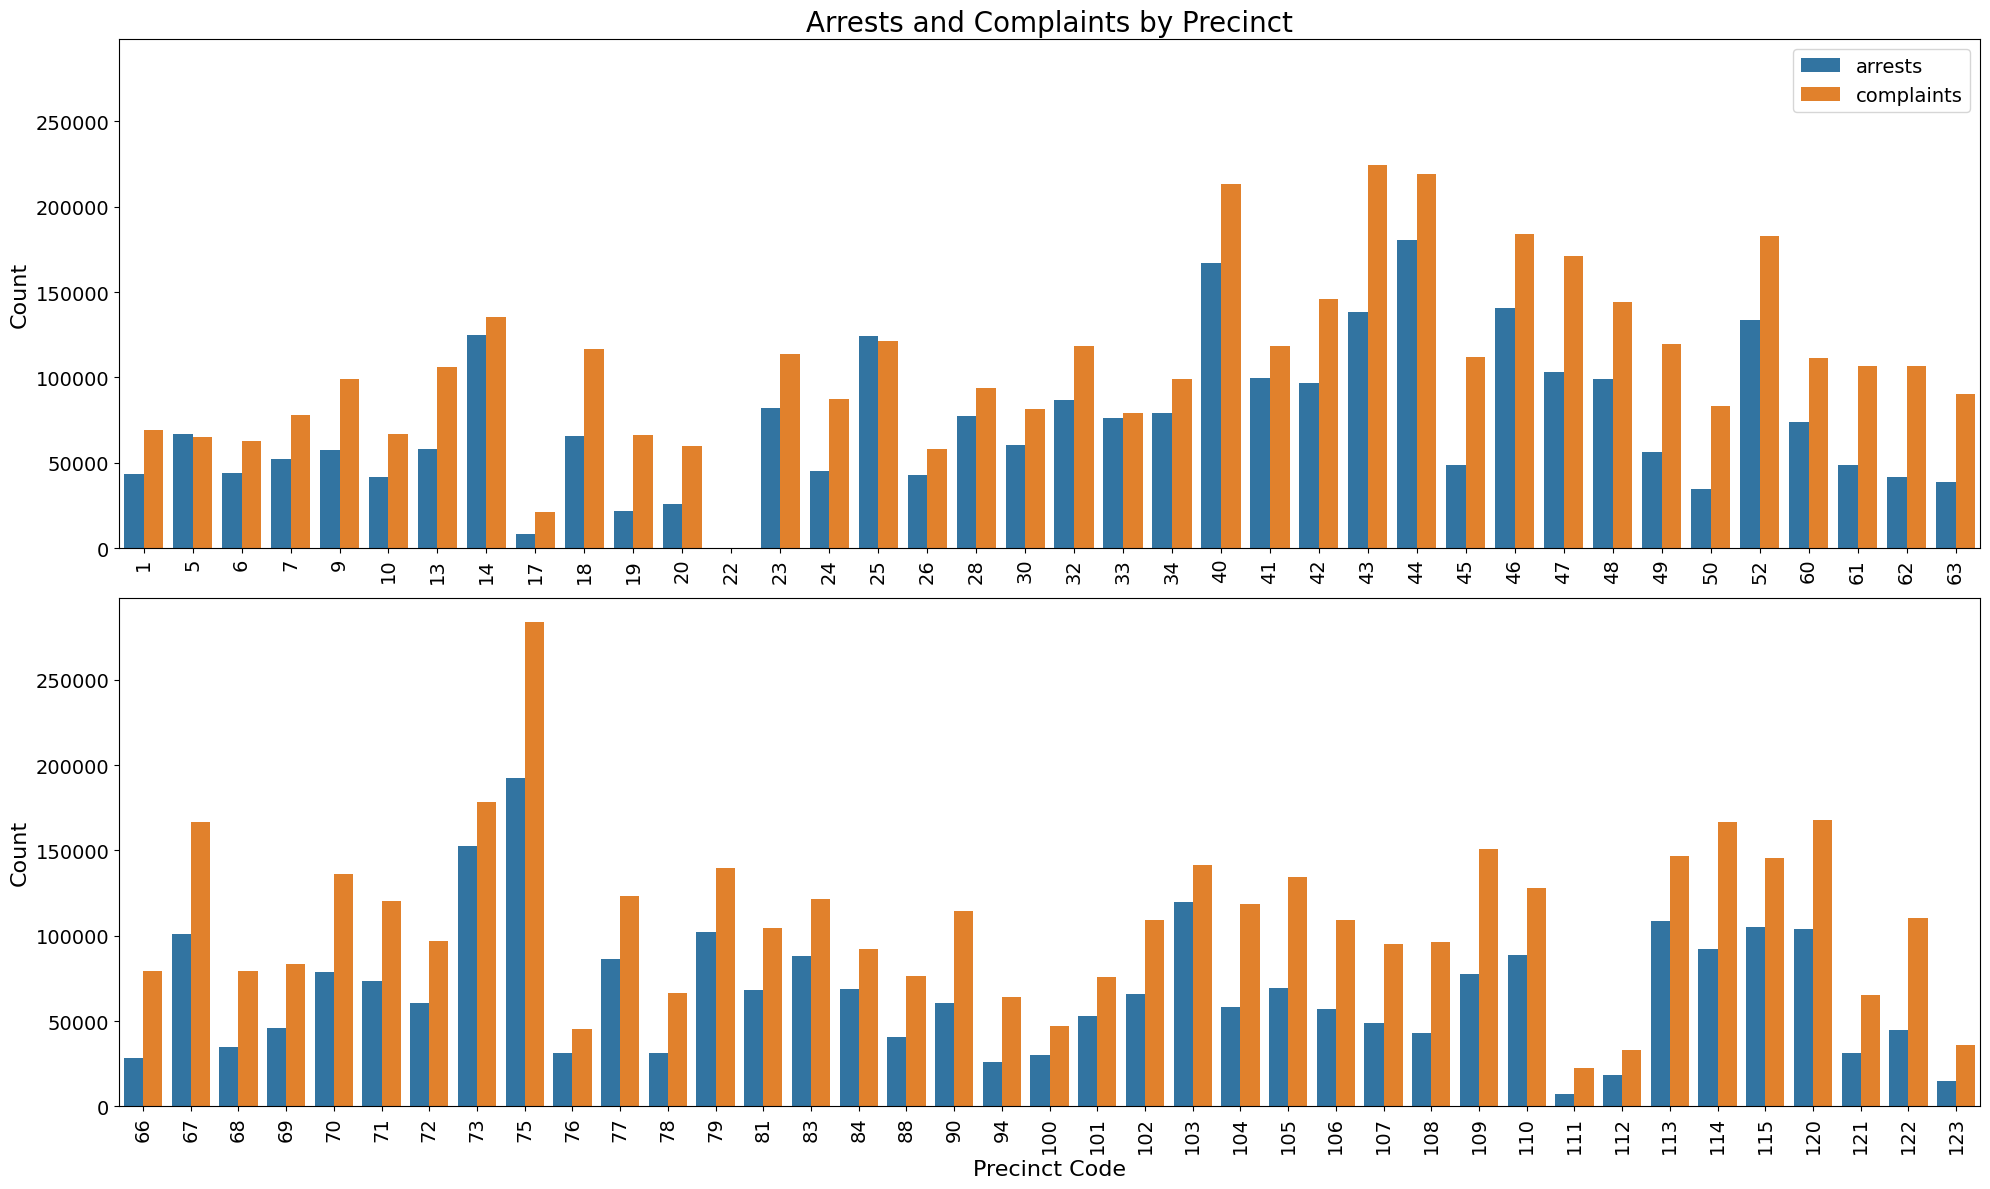

In [6]:
# Plotting and saving precinct arrest and complaint statistics for full data set
fig, ax = plt.subplots(2, 1, figsize = (20, 12), sharey = True)

precincts = precinct_agg_data.precinct.unique()
n = len(precincts)

func_params = {'x': 'precinct', 'y': 'value', 'hue': 'variable', 'palette': 'tab10'}
text_params = {'title': 'Arrests and Complaints by Precinct',
               'xlabel': 'Precinct Code', 'ylabel': 'Count', 'rotation': 90}
legend_params = {'title': None, 'fontsize': 14}
plot_params = {'agg_type': 'melt', 'annotate': False, 'save': False}

fig, ax[0] = plot_data(func = sns.barplot,
               data = precinct_agg_data[precinct_agg_data.precinct.isin(precincts[:n // 2])],
                       groupby_cols = ['precinct'],
                       target_cols = ['arrests', 'complaints'], ax = ax[0], func_params = func_params,
                       text_params = text_params, legend_params = legend_params, **plot_params);
fig, ax[1] = plot_data(func = sns.barplot,
               data = precinct_agg_data[precinct_agg_data.precinct.isin(precincts[n // 2:])],
                       groupby_cols = ['precinct'], target_cols = ['arrests', 'complaints'],
                       ax = ax[1], func_params = func_params,
                       text_params = text_params, legend_params = legend_params, **plot_params);

ax[0].set_xlabel('');
ax[1].set_title('');
ax[1].legend().remove();

plt.tight_layout();

plt.savefig('../visualizations/arrests_complaints_precinct.png', bbox_inches = 'tight')

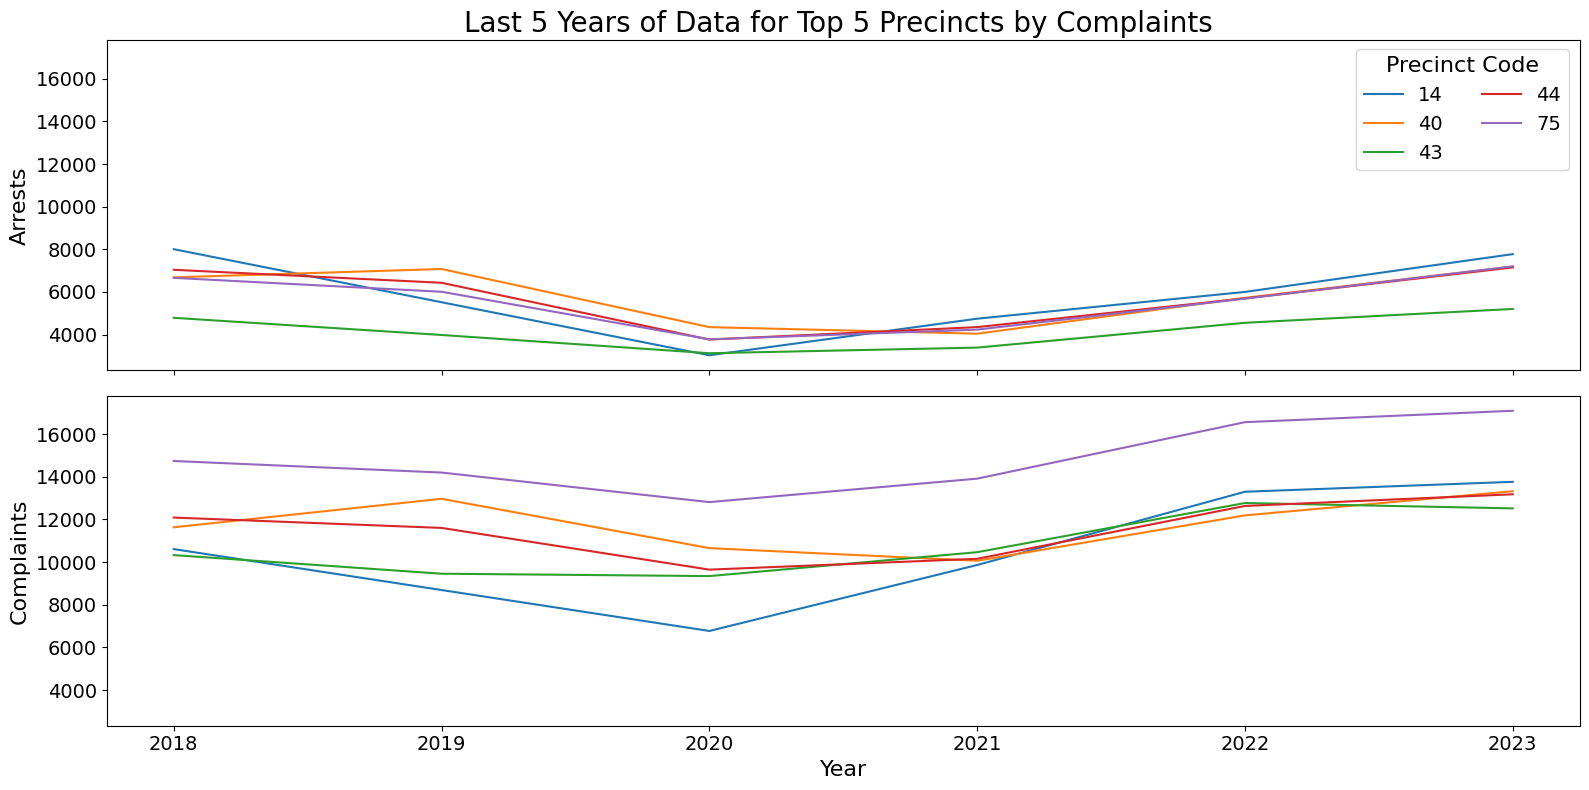

In [13]:
# Plotting and saving yearly precinct performance for the 5 highest activity precincts
top5_highest_activity_precincts = precinct_year_agg_data[precinct_year_agg_data.year >= 2018].groupby('precinct')\
                    .max().sort_values('complaints').nlargest(5, 'complaints').index.tolist()
top5_precinct_data = precinct_year_agg_data[(precinct_year_agg_data.year >= 2018)
                                & (precinct_year_agg_data.precinct.isin(top5_highest_activity_precincts))]

func_params = [{'x': 'year', 'y': 'arrests', 'hue': 'precinct', 'palette': 'tab10'},
               {'x': 'year', 'y': 'complaints', 'hue': 'precinct', 'palette': 'tab10'}]
text_params = [{'title': 'Last 5 Years of Data for Top 5 Precincts by Complaints ', 'xlabel': '', 'ylabel': 'Arrests'},
               {'title': '', 'xlabel': 'Year', 'ylabel': 'Complaints'}]
legend_params = {'title': 'Precinct Code', 'title_fontsize': 16,
                 'fontsize': 14, 'bbox_to_anchor': (0.99, 0.945), 'ncols': 2}
plot_params = {'agg_type': 'groupby', 'fig_width': 16, 'fig_height': 4, 'annotate': False, 'save': False}

fig, ax = plot_data(func = sns.lineplot, data = top5_precinct_data,
                    groupby_cols = ['year', 'precinct'], target_cols = ['arrests', 'complaints'],
                    func_params = func_params, text_params = text_params, legend_params = legend_params, **plot_params);

# Force x-labels to integers for whole years
ax[1].xaxis.set_major_locator(MaxNLocator(integer = True));

plt.savefig('../visualizations/top5_precincts.png', bbox_inches = 'tight');

In [27]:
# Close connection
conn.close()